In [359]:
library(tidyverse)

In [360]:
summary <- read_csv("summary.csv")
colnames(summary)

Rows: 2196 Columns: 32
── Column specification ────────────────────────────────────────────────
Delimiter: ","
chr  (7): Model, Locus_name, Model_string, Rates, parameters, Best, Percent_...
dbl (24): Likelihood, Unconstrained_likelihood, AIC, AICc, BIC, Length, Ntax...
lgl  (1): geodesic_distance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Model"                         "Locus_name"                   
 [3] "Model_string"                  "Rates"                        
 [5] "Likelihood"                    "Unconstrained_likelihood"     
 [7] "parameters"                    "AIC"                          
 [9] "AICc"                          "BIC"                          
[11] "Best"                          "Length"                       
[13] "Ntaxa"                         "Percent_constant"             
[15] "Percent_parsimony_informative" "Site_patterns"                
[17] "RF_distance"                   "nRF_distance"                 
[19] "wRF_distance"                  "KF_distance"                  
[21] "PD_distance"                   "wPD_distance"                 
[23] "geodesic_distance"             "Tree_Length"                  
[25] "Sum_int"                       "prop_int"                     
[27] "Min."                          "1st Qu."                      
[29] "Median"                        "Mean"                         
[31] "3rd Qu."                       "Max."

In [361]:
summary$Best %>% table()/2

.
  Mixture One_class 
     1008        90 

In [362]:
summary <- summary %>%
  mutate(Percent_parsimony_informative = str_remove(Percent_parsimony_informative, "%") %>% as.numeric()) %>%
  mutate(If_mix = str_detect(Model_string, "MIX"),
         Num_class = str_count(Model_string, ",") + 1)

summary <- summary %>%
  group_by(Locus_name) %>%
  mutate(If_mix = if(any(If_mix[Model == "Mixture"])) TRUE else FALSE) %>%
  ungroup()


In [363]:
summary$If_mix %>% table()/2
summary %>% filter(Model == "Mixture") %>% select(Num_class) %>% table()

.
FALSE  TRUE 
  756   342 

Num_class
  1   2   3   4 
756 206 119  17 

Warning message:
“Removed 4 rows containing non-finite values (`stat_density()`).”


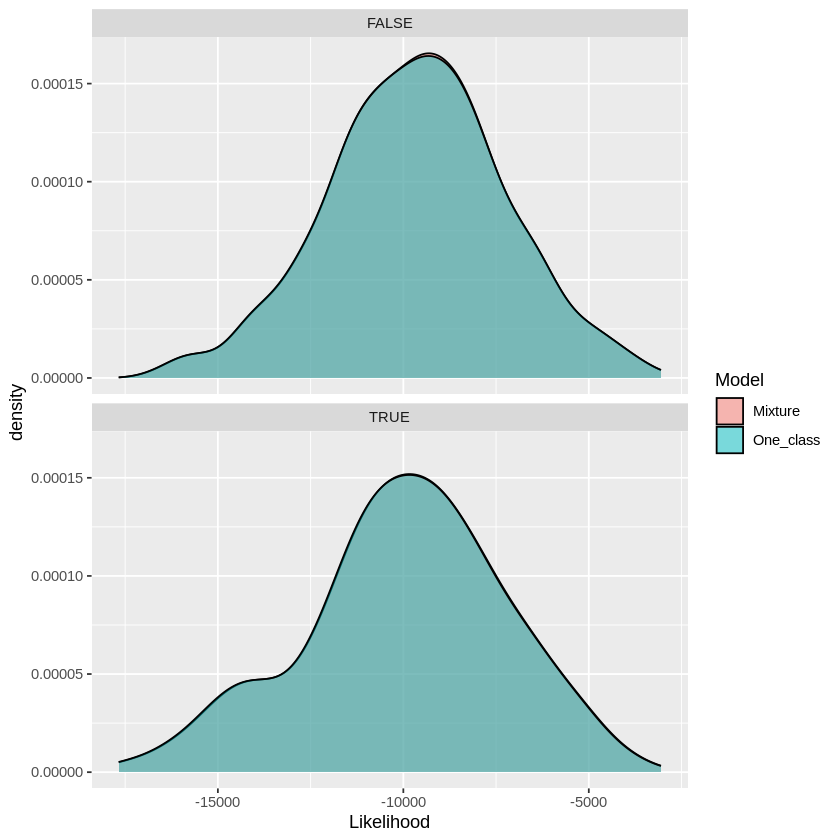

In [364]:
summary %>% ggplot(aes(x = Likelihood, fill = Model)) + geom_density(alpha = 0.5) + facet_wrap(~If_mix, nrow = 2)

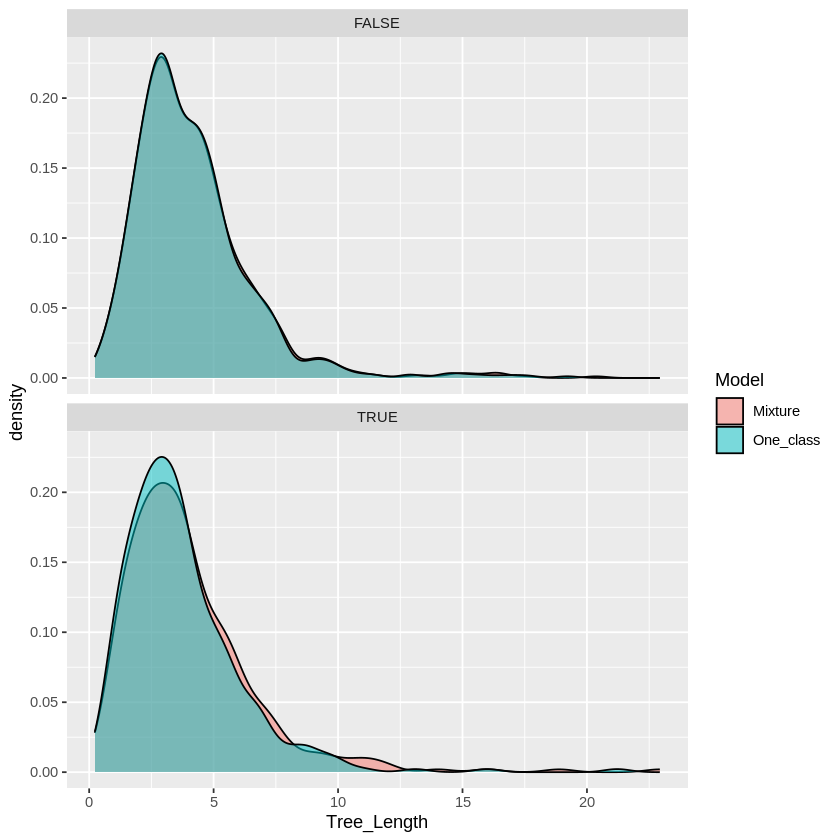

In [365]:
summary %>% ggplot(aes(x = Tree_Length, fill = Model)) + geom_density(alpha = 0.5) + facet_wrap(~If_mix, nrow = 2)

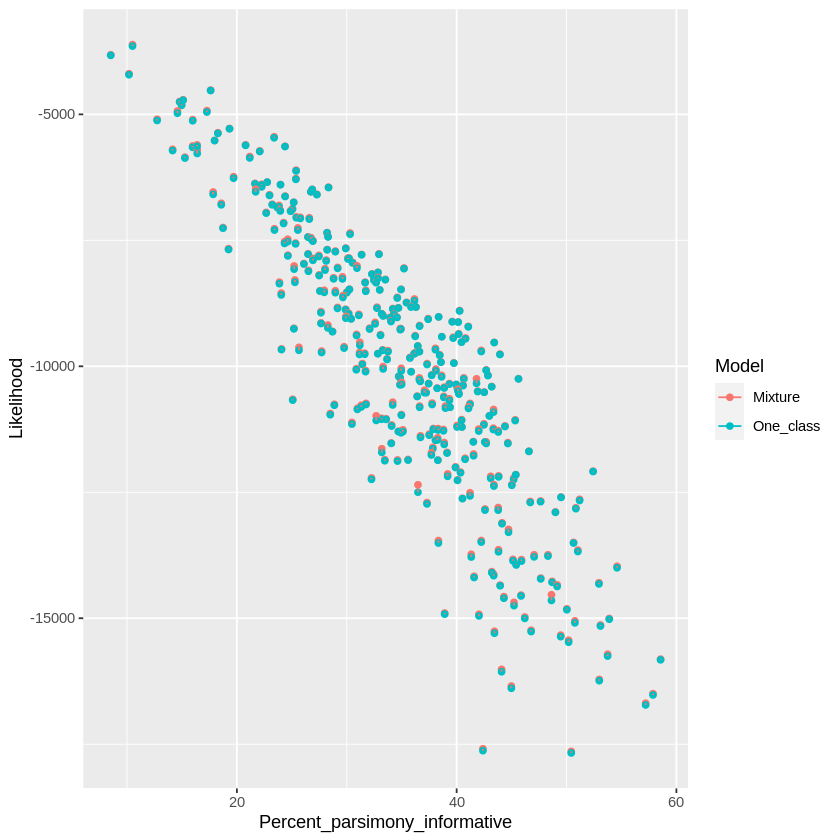

In [366]:
summary %>% filter(If_mix == TRUE) %>%
  ggplot(aes(x = Percent_parsimony_informative, y = Likelihood, color = Model, group = Locus_name)) + 
  geom_point() +
  geom_line()

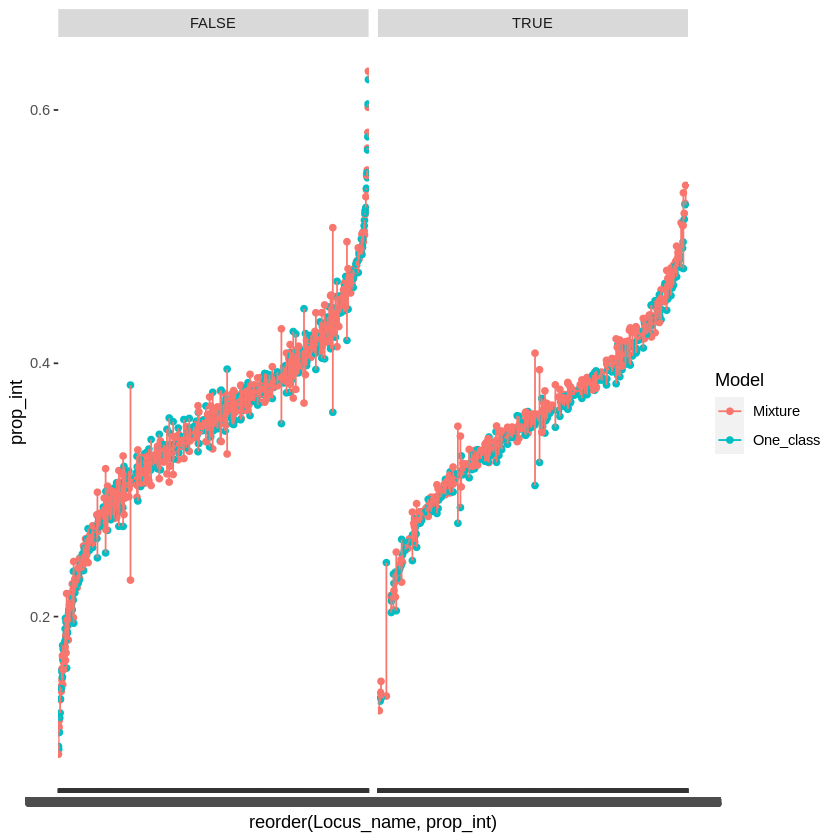

In [367]:
summary %>%
  ggplot(aes(x = reorder(Locus_name, prop_int), y = prop_int, color = Model, group = Locus_name)) + 
  geom_point() +
  geom_line() +
  facet_wrap(~If_mix)

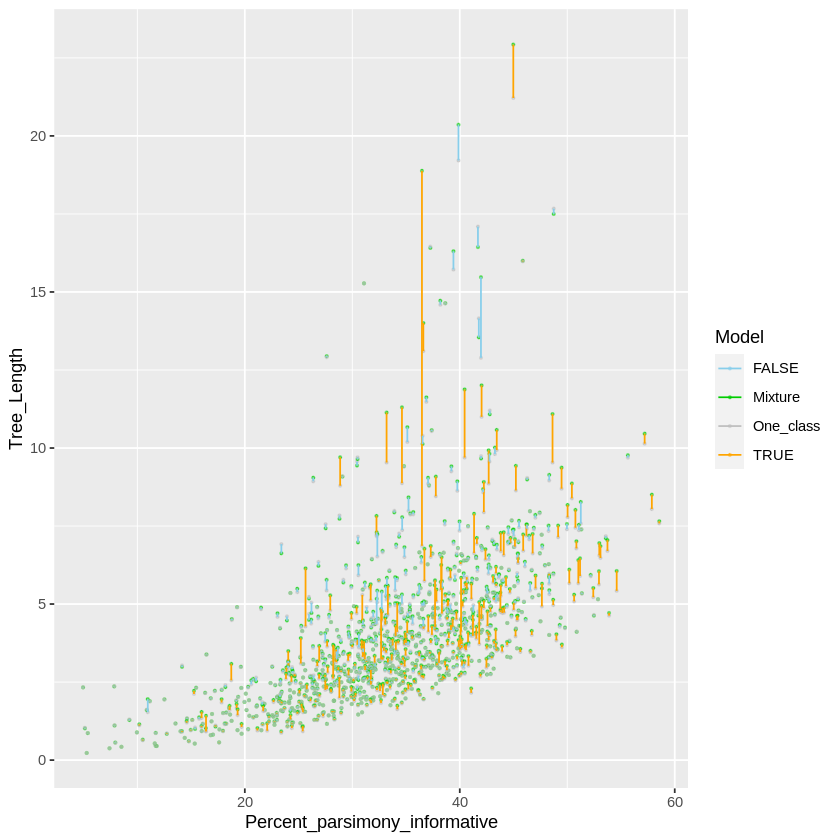

In [368]:
summary %>%
  ggplot(aes(x = Percent_parsimony_informative, y = Tree_Length, group = Locus_name)) + 
  geom_point(aes(color = Model), size = 0.5, alpha = 0.5) +
  geom_line(aes(color = If_mix)) +
  scale_color_manual(values = c("Mixture" = "green3", "One_class" = "gray", "TRUE" = "orange", "FALSE" = "skyblue"))


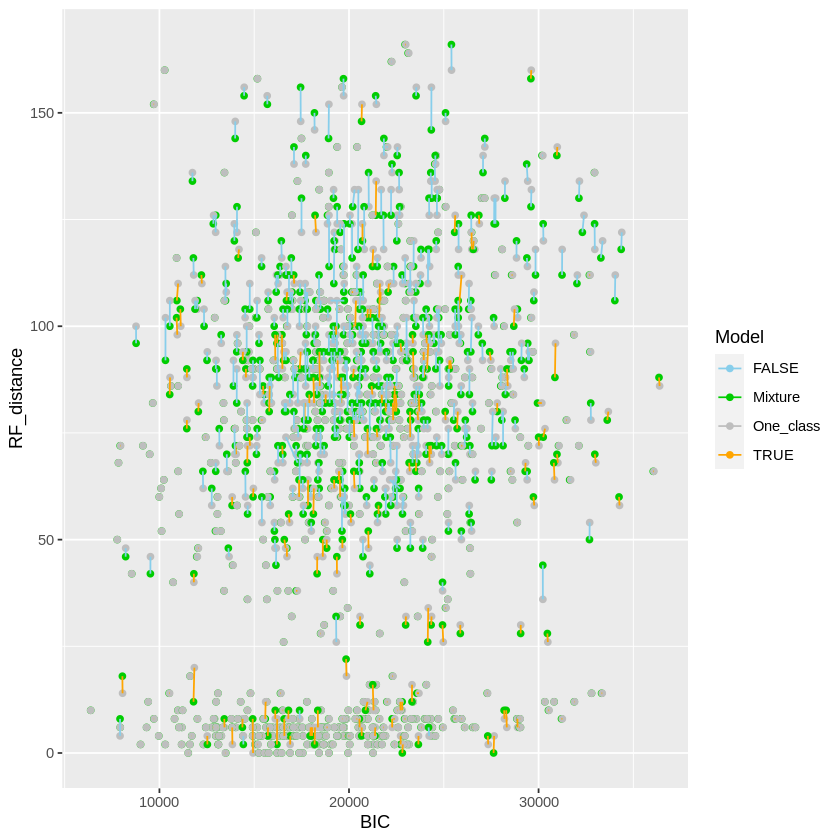

In [369]:
summary %>%
  ggplot(aes(x = BIC, y = RF_distance, group = Locus_name)) + 
  geom_point(aes(color = Model)) +
  geom_line(aes(color = If_mix)) +
  scale_color_manual(values = c("Mixture" = "green3", "One_class" = "gray", "TRUE" = "orange", "FALSE" = "skyblue"))


In [370]:
colnames(summary)

[1] "Model"                         "Locus_name"                   
 [3] "Model_string"                  "Rates"                        
 [5] "Likelihood"                    "Unconstrained_likelihood"     
 [7] "parameters"                    "AIC"                          
 [9] "AICc"                          "BIC"                          
[11] "Best"                          "Length"                       
[13] "Ntaxa"                         "Percent_constant"             
[15] "Percent_parsimony_informative" "Site_patterns"                
[17] "RF_distance"                   "nRF_distance"                 
[19] "wRF_distance"                  "KF_distance"                  
[21] "PD_distance"                   "wPD_distance"                 
[23] "geodesic_distance"             "Tree_Length"                  
[25] "Sum_int"                       "prop_int"                     
[27] "Min."                          "1st Qu."                      
[29] "Median"                        "Mean"                         
[31] "3rd Qu."                       "Max."                         
[33] "If_mix"                        "Num_class"

In [371]:
summary_diff <- summary %>%
  select(Model, Locus_name, where(is.numeric)) %>%
  select(-c(Length, Ntaxa, Percent_constant, Site_patterns, Num_class)) %>%
  gather(Parameter, Value, -Model, -Locus_name) %>%
  spread(Model, Value) %>%
  group_by(Locus_name, Parameter) %>%
  mutate(Difference =  Mixture - One_class) %>%
  ungroup() %>%
  select(-Mixture, -One_class) %>%
    pivot_wider(names_from = Parameter, values_from = Difference)

summary_diff_add <- summary %>%
  select(Model, Locus_name, If_mix, Best, Length, Ntaxa, Percent_constant, Percent_parsimony_informative, Site_patterns, Num_class) %>%
  filter(Model == "Mixture") %>%
  select(-Model)

summary_diff <- left_join(summary_diff, summary_diff_add, by = c("Locus_name"))

In [372]:
summary_diff_percent <- summary %>%
  select(Model, Locus_name, where(is.numeric)) %>%
  select(-c(Length, Ntaxa, Percent_constant, Site_patterns, Num_class)) %>%
  gather(Parameter, Value, -Model, -Locus_name) %>%
  spread(Model, Value) %>%
  group_by(Locus_name, Parameter) %>%
  mutate(Difference =  (Mixture - One_class)/One_class) %>%
  ungroup() %>%
  select(-Mixture, -One_class) %>%
    pivot_wider(names_from = Parameter, values_from = Difference)

summary_diff_percent_add <- summary %>%
  select(Model, Locus_name, If_mix, Best, Length, Ntaxa, Percent_constant, Percent_parsimony_informative, Site_patterns, Num_class) %>%
  filter(Model == "Mixture") %>%
  select(-Model)

summary_diff_percent <- left_join(summary_diff_percent, summary_diff_percent_add, by = c("Locus_name"))

Warning message:
“Removed 4 rows containing non-finite values (`stat_density()`).”


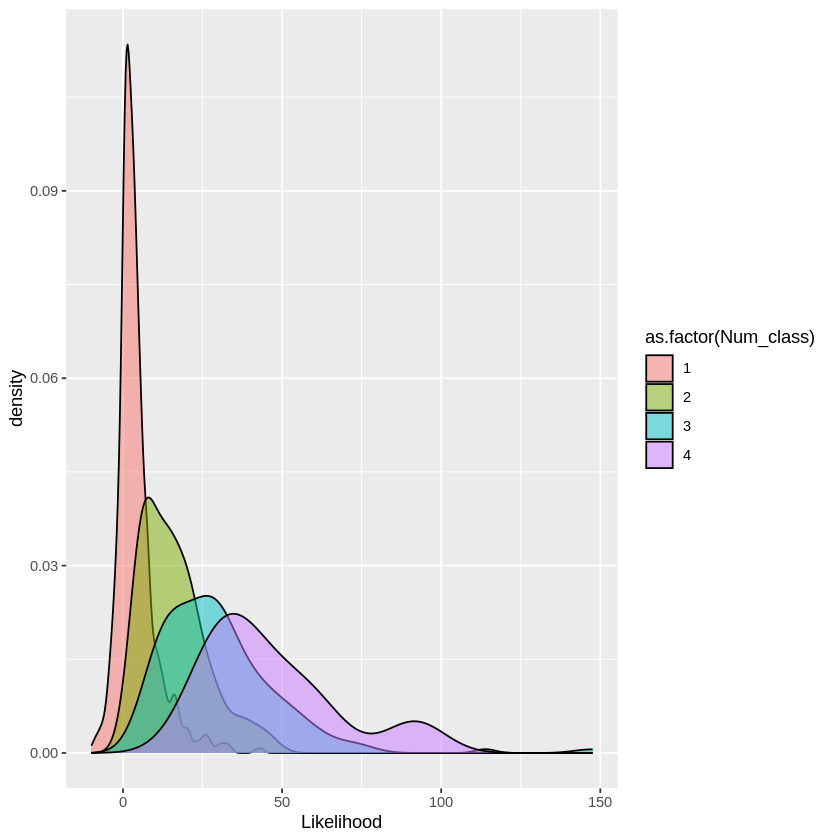

In [373]:
summary_diff %>% ggplot(aes(x = Likelihood, fill = as.factor(Num_class))) + 
  geom_density(alpha = 0.5)

Warning message:
“Removed 8 rows containing non-finite values (`stat_density()`).”


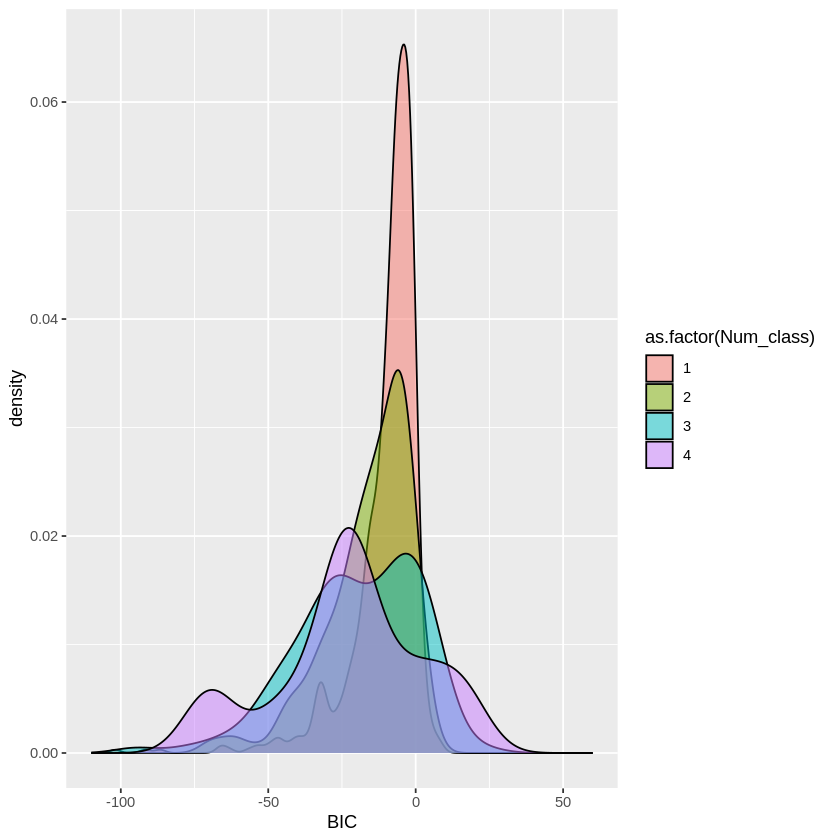

In [374]:
summary_diff %>% ggplot(aes(x = BIC, fill = as.factor(Num_class))) + 
  geom_density(alpha = 0.5) + xlim(-110,60)

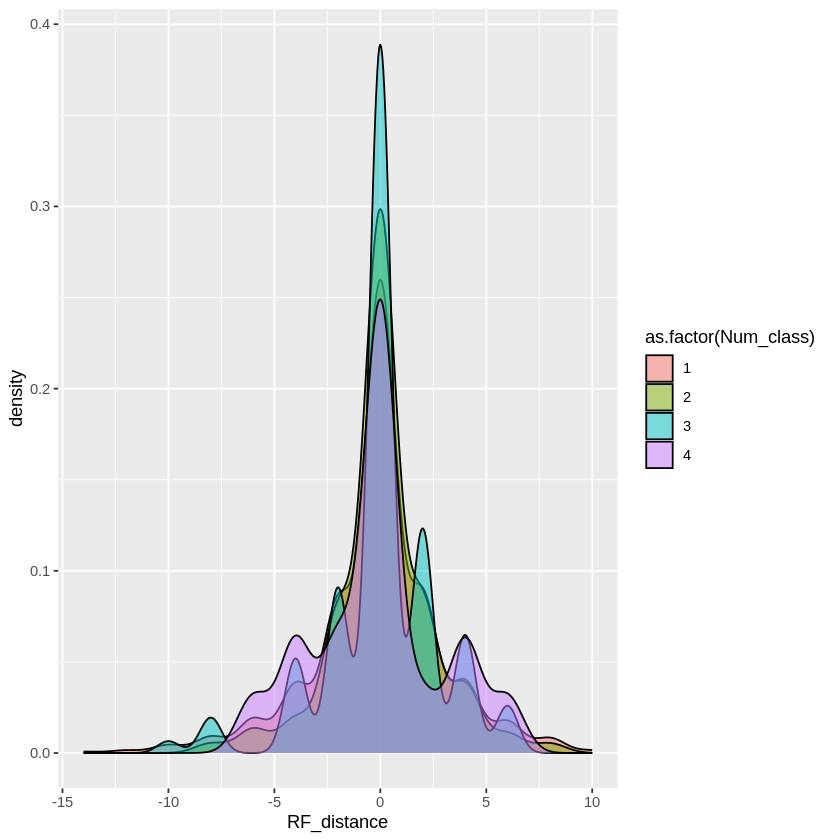

In [375]:
summary_diff %>% ggplot(aes(x = RF_distance, fill = as.factor(Num_class))) + 
  geom_density(alpha = 0.5)

In [376]:
high_diff_bl <- summary_diff_percent %>% filter(abs(Tree_Length) > 0.1) %>% select(Locus_name, Ntaxa, Tree_Length, If_mix, BIC, Tree_Length, RF_distance, Best)
table(high_diff_bl$If_mix)
table(high_diff_bl$Best)


FALSE  TRUE 
    6    53 


  Mixture One_class 
       53         6 

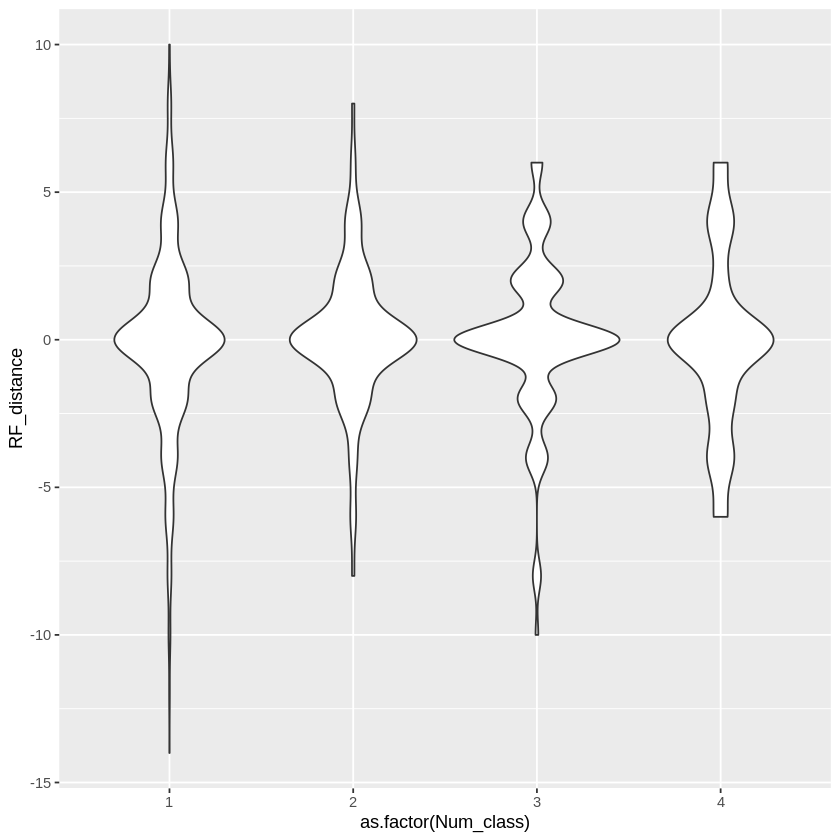

In [377]:
summary_diff %>% ggplot(aes(x = as.factor(Num_class), y= RF_distance)) + 
  geom_violin()

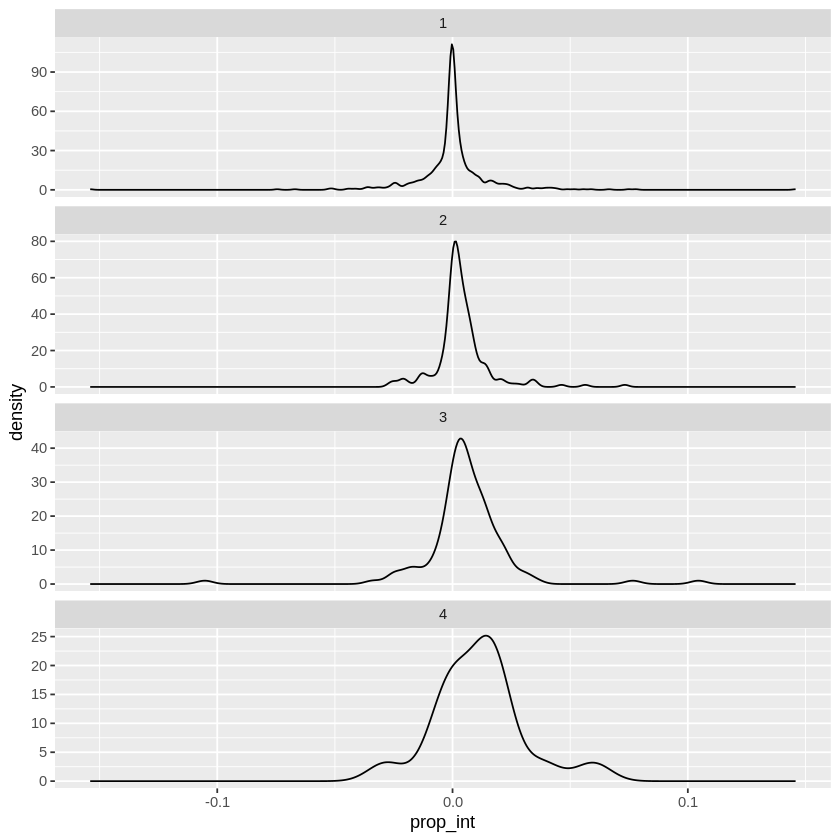

In [378]:
summary_diff %>% ggplot(aes(x = prop_int)) + 
    geom_density(alpha = 0.5) + facet_wrap(~Num_class, nrow = length(unique(summary_diff$Num_class)), scales = "free_y")